#### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### Importing datasets

In [2]:
df_centres = pd.read_csv('centers.csv')
df_dist = pd.read_csv('distances.csv')
df_demand = pd.read_csv("demands.csv")

In [3]:
df_demand.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Year    70 non-null     int64 
 1   Region  70 non-null     object
 2   Demand  70 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.8+ KB


In [4]:
# Having a look at the number of regions 
df_demand['Region'].unique()

array(['Downtown Toronto', 'East York', 'Etobicoke', 'Mississauga East',
       'North Toronto', 'North York', 'Scarborough East'], dtype=object)

In [5]:
df_dist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Center    42 non-null     object 
 1   Region    42 non-null     object 
 2   Distance  42 non-null     float64
dtypes: float64(1), object(2)
memory usage: 1.1+ KB


In [6]:
df_centres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Center            6 non-null      object
 1   Opening Costs     6 non-null      int64 
 2   Operating Costs   6 non-null      int64 
 3   Num MPs           6 non-null      int64 
 4   Maximum capacity  6 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 368.0+ bytes


#### Function definitions

In [7]:
def print_result(locationModel_obj):
    """
    This function prints whether the firm incurred a loss or a profit, and if so how much?
    """
    # Total profit
    diff = pulp.value(locationModel_obj.objective)
    if diff>0:
        print("Total profit: $ " + str(np.round(diff/1e6,4))+ " Million ")
    else:
        print("Total loss: $ " + str(-np.round(diff/1e6,4))+ " Million ")

In [8]:
def get_as_df(xvar):
    
    """
    
    Argument: Decision variable for demand met in hours
    Returns: Cleaned dataframe 
    
    This function returns a dataframe which retrieves the year, center allocated, 
    region they are allocated to and the number of hours served and formats it 
    and stores it in a pandas dataframe
    
    """
    
    results = {'Year':[], 'Center':[], 'Region':[], 'Served':[]}
    
    count = 0
    
    for t in periods:
        for i in depots:    
            for j in zones:
                results['Year'].append(t)
                results['Center'].append(i)
                results['Region'].append(j)
                results['Served'].append(xvar[(i,j,t)].varValue)
                count+=1
    
    df_temp = pd.DataFrame(results, index=range(count))
    df_temp = df_temp.pivot(index=['Year', 'Region'], columns=['Center'], values=['Served'])
    
    return df_temp

In [9]:
def workers_get_as_df(xvar):
    """
    
    Argument: Decision variable for demand met in hours
    Returns: Cleaned dataframe 
    
    This function returns a dataframe which retrieves the year, center allocated, 
    region they are allocated to and the total number of workers that serve at a particular region 
        
    """
    
    results = {'Year':[], 'Center':[], 'Region':[], 'Workers_Allocated':[]}
    
    count = 0
    
    for t in periods:
        for i in depots:    
            for j in zones:
                results['Year'].append(t)
                results['Center'].append(i)
                results['Region'].append(j)
                work_hrs = xvar[(i,j,t)].varValue
                workers = int(np.round(work_hrs/(250*6)))
                results['Workers_Allocated'].append(workers)
                count+=1
    
    df_temp = pd.DataFrame(results, index=range(count))
    df_temp = df_temp.pivot(index=['Year', 'Region'], columns=['Center'], values=['Workers_Allocated'])
    
    return df_temp

______

## Part 1. Forecasting demand : 2022, 23, 24

<AxesSubplot:xlabel='Year', ylabel='Demand'>

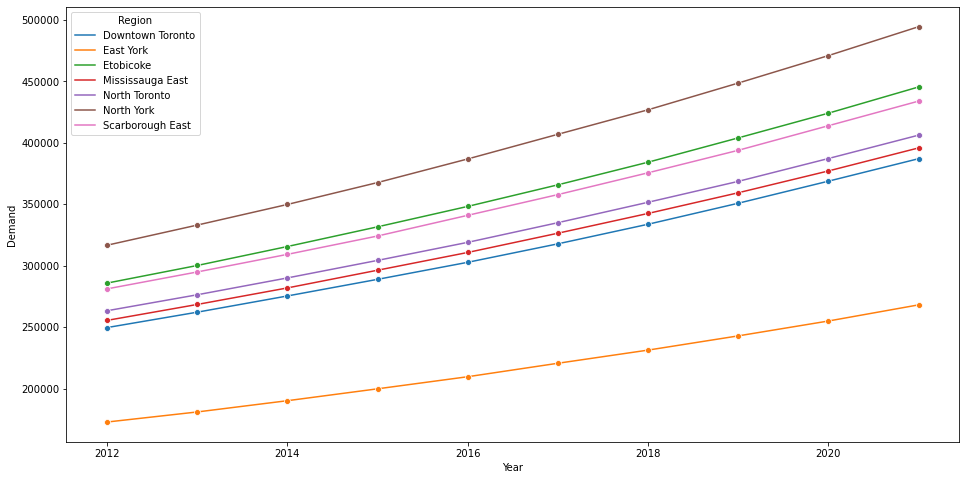

In [10]:
plt.figure(figsize=(16,8))
sns.lineplot(x='Year', y='Demand', hue = 'Region', marker="o",data=df_demand)

#### The demand seems to be growing steadily over the years, so we can assume the demand to follow a linear relationship


#### Making a Linear Regression Model to forecast the demand for next 4 years (2022 to 2025)

In [11]:
#Linear Regression Model
from sklearn.linear_model import LinearRegression

# Creating a function to forecast the demand for various regions
def model_fn(dff,reg):
    
    dff = dff[dff['Region']==reg]
    yr = dff['Year'].max()
    
    lm = LinearRegression()
    X_train = dff[['Year']]
    y_train = dff['Demand']
    
    lm.fit(X_train,y_train)
    
    X_test = pd.DataFrame({'Year' : [yr+1,yr+2,yr+3]})
    y_pred = lm.predict(X_test)
    
    X_test['Region'] = reg
    X_test['Demand'] = np.round(y_pred,0)
        
    return X_test

# Storing all the forecasted values in a new df
df_forecast = pd.DataFrame(columns=['Year','Region','Demand'])
for i in df_demand['Region'].unique():
    df_forecast = df_forecast.append(model_fn(df_demand,i))

df_forecast = df_forecast.reset_index(drop = True)

Having a look at the forecasted values to check if they align with the original trend

<AxesSubplot:xlabel='Year', ylabel='Demand'>

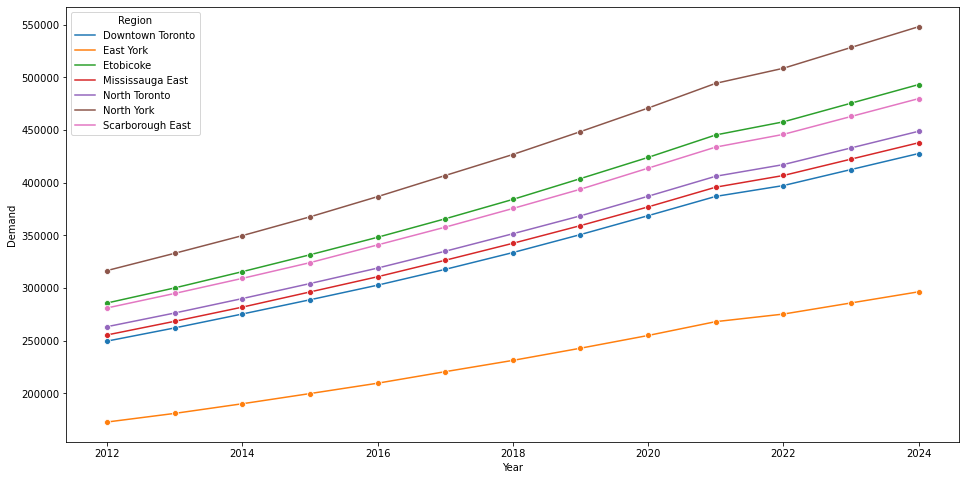

In [12]:
df_demand_all = df_demand.append(df_forecast).reset_index(drop=True)

plt.figure(figsize=(16,8))
sns.lineplot(x='Year', y='Demand', hue = 'Region',marker="o", data=df_demand_all)

#### The forecasted values seem to follow the general demand trend

____________
### Data Cleaning 

#### Finding the total number of medical professionals at the start of 2022

In [13]:
total_MPs = df_centres['Num MPs'].sum()
total_MPs

560

In [14]:
# Zone-depot costs
dfZoneDepot = df_dist.copy()
dfZoneDepot['Cost_per_hr'] = dfZoneDepot['Distance']*0.25
dfZoneDepot.head()

,Center,Region,Distance,Cost_per_hr
0,Center A,Downtown Toronto,25.77,6.4425
1,Center A,East York,2.24,0.5600
2,Center A,Etobicoke,25.72,6.4300
3,Center A,Mississauga East,28.65,7.1625
4,Center A,North Toronto,11.64,2.9100


In [15]:
# Depots
dfDepots = df_centres.copy()
dfDepots = dfDepots.set_index(['Center'])
dfDepots

,Opening Costs,Operating Costs,Num MPs,Maximum capacity
Center,,,,
Center A,0,275000,215,5000000
Center B,0,275000,125,5000000
Center C,0,275000,100,5000000
Center D,0,285000,120,5000000
Center E,250000,125000,0,5000000
Center F,100000,175000,0,5000000


#### Sets

In [16]:
# Depots = Centres
depots = list(dfDepots.index)
numdepots = len(depots)

# Demand zones = Regions
zones = list(dfZoneDepot["Region"].unique())
numzones = len(zones)

In [17]:
# For Q3 and Q4
# Periods
periods = [2022,2023,2024]
numperiods = len(periods)

#### Parameters

In [18]:
# Depot costs (dictionary)
depotcost_open = {} #Opening costs
depotcost_opt = {} #Operating costs

# Depot capacities (dictionary)
depotcapacity = {}

#Loop
for i in depots:
    depotcost_open[i] = float(dfDepots.loc[i]["Opening Costs"])
    depotcost_opt[i] = float(dfDepots.loc[i]["Operating Costs"])
    depotcapacity[i] = int(dfDepots.loc[i]["Maximum capacity"])
  

In [19]:
# Depot-zone costs (dictionary)
depotzonecost = {}
for i in depots:
    for j in zones:
        depotzonecost[(i,j)] = float(dfZoneDepot[(dfZoneDepot["Center"] == i)&(dfZoneDepot["Region"] == j)]["Cost_per_hr"])
    
# Demand in each zone (dictionary)
zonedemand = {}
for t in periods:
    for j in zones:    
        zonedemand[(j,t)] = int(df_forecast[(df_forecast["Year"] == t)&(df_forecast["Region"] == j)]['Demand'])


# Operating depots:
y = {}
for depot in depots:
    if depotcost_open[depot] == 0.0:
        y[depot] = 1
    else:
        y[depot] = 0

____

## 2. A simple allocation model for the year: 2022

In [20]:
from scipy import stats
import pulp

In [21]:
df_forecast.head()

,Year,Region,Demand
0,2022,Downtown Toronto,397296.0
1,2023,Downtown Toronto,412507.0
2,2024,Downtown Toronto,427718.0
3,2022,East York,275251.0
4,2023,East York,285828.0


In [22]:
#Only considering demand for 2022
dfZones22 = df_forecast[df_forecast['Year']==2022].drop('Year',axis=1).set_index(['Region'])
dfZones22

# Demand in each zone (dictionary) -- For 2022
zonedemand22 = {}
for j in zones:    
    zonedemand22[j] = float(dfZones22.loc[j]["Demand"])

#### Variables

In [23]:
#Number of workers at various centers
wvar = pulp.LpVariable.dict("w", (depots), lowBound=0.0, cat=pulp.LpInteger)

# Variables: if a depot is opened/allocated
yvar = pulp.LpVariable.dict("y", depots, cat=pulp.LpBinary)

# Variables: amount of demand from each zone allocated to depot, per scenario
xvar = pulp.LpVariable.dict("x", (depots, zones), lowBound=0.0, cat=pulp.LpContinuous)

#### Model

In [24]:
# Initialize model and objective sense
locationModel_2 = pulp.LpProblem(name="LocationModel", sense=pulp.LpMaximize)

#### Constraints

In [25]:
# Contraint: demand must be satisfied in all scenarios
for j in zones:
    locationModel_2 += pulp.lpSum( [xvar[(i,j)] for i in depots] ) <= zonedemand22[j]

# Constraint: depot capacities must be observed in all scenarios
for i in depots:        
    locationModel_2 += pulp.lpSum( [xvar[(i,j)] for j in zones] ) <= depotcapacity[i] * yvar[i]
    locationModel_2 += pulp.lpSum( [xvar[(i,j)] for j in zones] ) <= wvar[i] *6*250

locationModel_2 += pulp.lpSum( [wvar[i] for i in depots] ) <= total_MPs

#### Objective function

In [26]:
rate = 42 # amount reimbursed

# Revenue earned = Govt. reimbursement
obj_rev22 = pulp.lpSum( [ rate * xvar[(i,j)] for i in depots for j in zones ] )

# Center operating costs --> As these depots are already open
obj_cost22 = pulp.lpSum([ depotcost_opt[i] for i in ['Center A', 'Center B', 'Center C', 'Center D']] ) 

# Center operating + opening costs --> Decision is to be made whether it has to be opened or not
obj_cost22 += pulp.lpSum([ (depotcost_open[i] + depotcost_opt[i]) * yvar[i] for i in ['Center E', 'Center F'] ])

# Package flow costs
obj_cost22 += pulp.lpSum( [ depotzonecost[(i,j)] * xvar[(i,j)] for i in depots for j in zones ] )

# Salary of workers
obj_cost22 += pulp.lpSum( [ 37.85*6*250* wvar[i] for i in depots] )

obj22 = obj_rev22 - obj_cost22

# Add objective to model
locationModel_2 += obj22

#### Results

In [27]:
# Write LP to file (optional, but often good to inspect model and find errors)
#locationModel.writeLP("locationModel.lp")

# Solve model
locationModel_2.solve()
print("Status:", pulp.LpStatus[locationModel_2.status])

Status: Optimal


In [28]:
# Total Profits
print_result(locationModel_2)

Total profit: $ 2.376 Million 


In [29]:
# Print solution (you can add to the dataframe if needed)
for i in depots:
    if yvar[i].varValue >= 1.0:
        print(str(i) + " is open")                            
        for j in zones:
            if xvar[(i,j)].varValue > 0.0:
                print("\tServes zone " + str(j) + " | hours = " + str(xvar[(i,j)].varValue) + " | Workers assigned = "+ str(wvar[i].varValue))

Center A is open
	Serves zone North York | hours = 433500.0 | Workers assigned = 289.0
Center B is open
Center C is open
Center D is open
	Serves zone Mississauga East | hours = 406500.0 | Workers assigned = 271.0


#### Analysis

In [30]:
df_dist[df_dist['Center'] == 'Center A'].sort_values(by = "Distance")

,Center,Region,Distance
5,Center A,North York,0.00
1,Center A,East York,2.24
4,Center A,North Toronto,11.64
6,Center A,Scarborough East,19.76
2,Center A,Etobicoke,25.72
0,Center A,Downtown Toronto,25.77
3,Center A,Mississauga East,28.65


In [31]:
df_dist[df_dist['Center'] == 'Center D'].sort_values(by = "Distance")

,Center,Region,Distance
24,Center D,Mississauga East,0.00
22,Center D,East York,16.04
26,Center D,North York,22.98
25,Center D,North Toronto,25.05
27,Center D,Scarborough East,26.78
21,Center D,Downtown Toronto,29.88
23,Center D,Etobicoke,31.11


___

## 3. Allocation of existing medical professionals throughout the years

#### Variables

In [32]:
# Variables: if a depot is opened/allocated
yvar = pulp.LpVariable.dict("y", (depots, [2021]+periods), cat=pulp.LpBinary)

# Variables: amount of demand from each zone allocated to depot, per scenario
xvar = pulp.LpVariable.dict("x", (depots, zones, periods), lowBound=0.0, cat=pulp.LpContinuous)

# Worker flow
wvar = pulp.LpVariable.dict("w", (depots, [2021]+periods), lowBound=0, cat=pulp.LpInteger)

#### Model

In [33]:
# Initialize model and objective sense
locationModel_3 = pulp.LpProblem(name="LocationModel", sense=pulp.LpMaximize)

#### Constraints

In [34]:
# Balance of flow constraints

for m in ([2021]+periods):
    locationModel_3 += pulp.lpSum( [ wvar[(i, m)] for i in depots ] ) == (total_MPs)

for t in periods:
    for j in zones:
        # Contraint: demand must be satisfied in all scenario
        locationModel_3 += (pulp.lpSum( [xvar[(i,j,t)] for i in depots] ) <= zonedemand[(j,t)])

    for i in ['Center A', 'Center B', 'Center C', 'Center D']:
        locationModel_3 += ( yvar[(i, 2021)] == 1 )
        locationModel_3 += ( yvar[(i, t)] == 1 )
  
    for i in ['Center E', 'Center F']: 
        locationModel_3 += ( yvar[(i, 2021)] == 0 )
        locationModel_3 += ( yvar[(i, t)] >= yvar[(i, t-1)] )

    for i in depots:
        # Constraint: depot capacities must be observed in all scenarios
        locationModel_3 += pulp.lpSum( [xvar[(i,j,t)] for j in zones] ) <= depotcapacity[i] * yvar[(i,t)]

        # Worker flow
        locationModel_3 += (wvar[(i,t)] == wvar[(i,t-1)])

        # Capacity limited by workers
        locationModel_3 += pulp.lpSum( [xvar[(i,j,t)] for j in zones] ) <= 250 * 6 * wvar[(i,t)]

#### Objective Function

In [35]:
# Objective function

rate = 42 # amount reimbursed

# Center allocation costs
obj_3 = -( pulp.lpSum([ depotcost_open[i] * yvar[(i,2024)] for i in depots] ) )

for t in periods:
  
    # Revenue earned through reimbursement by the governement
    obj_3 += pulp.lpSum( [ rate * xvar[(i,j,t)] for i in depots for j in zones ] )

    # Distance costs
    obj_3 -= pulp.lpSum( [ depotzonecost[(i,j)] * xvar[(i,j,t)] for i in depots for j in zones ] )

    # Center operating cost
    obj_3 -= pulp.lpSum( [ depotcost_opt[i] * yvar[(i,t)] for i in depots] )

    # Health professional cost
    obj_3 -= pulp.lpSum( [ (37.85 * 250 * 6) * (1.025**(t-2022)) * wvar[(i,t)] for i in depots ] )

# Add objective to model
locationModel_3 += obj_3

#### Model Results

In [36]:
# Solve model
locationModel_3.solve()
print("Status:", pulp.LpStatus[locationModel_3.status])

Status: Optimal


In [37]:
print_result(locationModel_3)

Total profit: $ 4.7236 Million 


In [38]:
for t in periods:
    print('\nYear', t)
    for i in depots:
        num_MPs = wvar[(i,t)].varValue
        if(num_MPs>0):
            print('\t', i, '--> Total Medical Professionals :', int(np.floor(num_MPs)))


Year 2022
	 Center A --> Total Medical Professionals : 289
	 Center D --> Total Medical Professionals : 271

Year 2023
	 Center A --> Total Medical Professionals : 289
	 Center D --> Total Medical Professionals : 271

Year 2024
	 Center A --> Total Medical Professionals : 289
	 Center D --> Total Medical Professionals : 271


In [39]:
for t in periods:
    print('_'*100)
    print('\n Year ', t)
    for i in depots:
        if yvar[(i,t)].varValue >= 1.0:
            print("\n\t" + str(i) + " is Open")
        else:
            print("\n\t" + str(i) + " is Closed")
        for j in zones:
            if xvar[(i,j,t)].varValue > 0.0:
                print("\t\tServes " + str(j) + " | hours = " + str(int(xvar[(i,j,t)].varValue)))
    print()

____________________________________________________________________________________________________

 Year  2022

	Center A is Open
		Serves North York | hours = 433500

	Center B is Open

	Center C is Open

	Center D is Open
		Serves Mississauga East | hours = 406500

	Center E is Closed

	Center F is Closed

____________________________________________________________________________________________________

 Year  2023

	Center A is Open
		Serves North York | hours = 433500

	Center B is Open

	Center C is Open

	Center D is Open
		Serves Mississauga East | hours = 406500

	Center E is Closed

	Center F is Closed

____________________________________________________________________________________________________

 Year  2024

	Center A is Open
		Serves North York | hours = 433500

	Center B is Open

	Center C is Open

	Center D is Open
		Serves Mississauga East | hours = 406500

	Center E is Closed

	Center F is Closed



In [40]:
get_as_df(xvar)

Served                                              
Center                 Center A Center B Center C  Center D Center E Center F
Year Region                                                                  
2022 Downtown Toronto       0.0      0.0      0.0       0.0      0.0      0.0
     East York              0.0      0.0      0.0       0.0      0.0      0.0
     Etobicoke              0.0      0.0      0.0       0.0      0.0      0.0
     Mississauga East       0.0      0.0      0.0  406500.0      0.0      0.0
     North Toronto          0.0      0.0      0.0       0.0      0.0      0.0
     North York        433500.0      0.0      0.0       0.0      0.0      0.0
     Scarborough East       0.0      0.0      0.0       0.0      0.0      0.0
2023 Downtown Toronto       0.0      0.0      0.0       0.0      0.0      0.0
     East York              0.0      0.0      0.0       0.0      0.0      0.0
     Etobicoke              0.0      0.0      0.0       0.0      0.0      0.0
     Mississauga East       0.0      0.0      0.0  406500.0      0.0      0.0
     North Toronto          0.0      0.0      0.0       0.0      0.0      0.0
     North York        433500.0      0.0      0.0       0.0      0.0      0.0
     Scarborough East       0.0      0.0      0.0       0.0      0.0      0.0
2024 Downtown Toronto       0.0      0.0      0.0       0.0      0.0      0.0
     East York              0.0      0.0      0.0       0.0      0.0      0.0
     Etobicoke              0.0      0.0      0.0       0.0      0.0      0.0
     Mississauga East       0.0      0.0      0.0  406500.0      0.0      0.0
     North Toronto          0.0      0.0      0.0       0.0      0.0      0.0
     North York        433500.0      0.0      0.0       0.0      0.0      0.0
     Scarborough East       0.0      0.0      0.0       0.0      0.0      0.0

_________

## 4a. Hiring workers & Maximizing profits

#### Variables

In [41]:
# Variables: if a depot is opened/allocated
yvar = pulp.LpVariable.dict("y", (depots, [2021]+periods), cat=pulp.LpBinary)

# Variables: amount of demand from each zone allocated to depot, per scenario
xvar = pulp.LpVariable.dict("x", (depots, zones, periods), lowBound=0.0, cat=pulp.LpContinuous)

# Worker flow
wvar = pulp.LpVariable.dict("w", (depots, [2021]+periods), lowBound=0, cat=pulp.LpContinuous)

# New hires
hvar = pulp.LpVariable.dict("h", (depots, periods), lowBound=0, cat=pulp.LpContinuous)

#### Model initialization

In [42]:
locationModel_4 = pulp.LpProblem(name="LocationModel", sense=pulp.LpMaximize)

#### Constraints

In [43]:
for t in periods:
    
    for j in zones:
        # Contraint: demand must be satisfied in all scenarios
        locationModel_4 += (pulp.lpSum( [xvar[(i,j,t)] for i in depots] ) <= zonedemand[(j,t)])
    
    for i in depots:
        # Constraint: depot capacities must be observed in all scenarios
        locationModel_4 += pulp.lpSum( [xvar[(i,j,t)] for j in zones] ) <= depotcapacity[i] * yvar[(i,t)]
        
        # Maximum number of hires
        locationModel_4 += pulp.lpSum( hvar[(i,t)] ) <= 300
        
        # Worker flow -  Balance of flow constraints
        if t == 2022:
            locationModel_4 += pulp.lpSum( [ wvar[(i,t-1)] for i in depots ] ) <= (total_MPs)
        
        numworkers = wvar[(i,t-1)] + hvar[(i,t)]
        locationModel_4 += (wvar[(i,t)] == numworkers)
        
        # Capacity limited by workers
        locationModel_4 += pulp.lpSum( [xvar[(i,j,t)] for j in zones] ) <= 250 * 6 * wvar[(i,t)]
    
        

    #Constraints for opening of new centers
    for i in ['Center A', 'Center B', 'Center C', 'Center D']:
        locationModel_4 += ( yvar[(i, 2021)] == 1 )
        locationModel_4 += ( yvar[(i, t)] == 1 )
  
    for i in ['Center E', 'Center F']: 
        locationModel_4 += ( yvar[(i, 2021)] == 0 )
        locationModel_4 += ( yvar[(i, t)] >= yvar[(i, t-1)] )   

#### Objective function

In [44]:
# Objective function
rate = 42

# Depot allocation costs
obj_4 = -pulp.lpSum([ depotcost_open[i] * yvar[(i,2024)] for i in depots] )

for t in periods:
    
    # Revenue earned through reimbursement by the governement
    obj_4 += pulp.lpSum( [ rate * xvar[(i,j,t)] for i in depots for j in zones ] )
    
    # Distance costs
    obj_4 -= pulp.lpSum( [ depotzonecost[(i,j)] * xvar[(i,j,t)] for i in depots for j in zones ] )

    obj_4 -= pulp.lpSum([ depotcost_opt[i] * yvar[(i,t)] for i in depots] )

    # Workers' pay
    obj_4 -= pulp.lpSum( [ (37.85 * 250 * 6) * (1.025**(t-2022)) * wvar[(i,t)] for i in depots ] )

    # Hiring costs
    obj_4 -= pulp.lpSum( [ 15000 * hvar[(i,t)] for i in depots ] )

# Add objective to model
locationModel_4 += obj_4

#### Model Results

In [45]:
locationModel_4.solve()
print("Status:", pulp.LpStatus[locationModel_4.status])

Status: Optimal


In [46]:
print_result(locationModel_4)

Total profit: $ 4.7236 Million 


In [47]:
for t in periods:
    print('_'*100)
    print('\n Year ', t)
    for i in depots:
        if yvar[(i,t)].varValue >= 1.0:
            print("\n\t" + str(i) + " is Open")
        else:
            print("\n\t" + str(i) + " is Closed")
        for j in zones:
            if xvar[(i,j,t)].varValue > 0.0:
                print("\t\tServes " + str(j) + " | hours served = " + str(int(xvar[(i,j,t)].varValue)))
    print()

____________________________________________________________________________________________________

 Year  2022

	Center A is Open
		Serves North York | hours served = 508686

	Center B is Open
		Serves Scarborough East | hours served = 331314

	Center C is Open

	Center D is Open

	Center E is Closed

	Center F is Closed

____________________________________________________________________________________________________

 Year  2023

	Center A is Open
		Serves North York | hours served = 508686

	Center B is Open
		Serves Scarborough East | hours served = 331314

	Center C is Open

	Center D is Open

	Center E is Closed

	Center F is Closed

____________________________________________________________________________________________________

 Year  2024

	Center A is Open
		Serves North York | hours served = 508686

	Center B is Open
		Serves Scarborough East | hours served = 331314

	Center C is Open

	Center D is Open

	Center E is Closed

	Center F is Closed



In [48]:
for t in periods:
    print('\nYear', t)
    for i in depots:
        num_MPs = wvar[(i,t)].varValue
        num_MPs = int(np.round(num_MPs))
        
        num_hired = int(np.round(hvar[(i,t)].varValue))
        org_count = num_MPs - num_hired
        
        if(num_MPs>0):
            print('\t', i, '--> Had ',org_count,'MPs | New Hires : ',num_hired,' | Total MPs',num_MPs )


Year 2022
	 Center A --> Had  339 MPs | New Hires :  0  | Total MPs 339
	 Center B --> Had  221 MPs | New Hires :  0  | Total MPs 221

Year 2023
	 Center A --> Had  339 MPs | New Hires :  0  | Total MPs 339
	 Center B --> Had  221 MPs | New Hires :  0  | Total MPs 221

Year 2024
	 Center A --> Had  339 MPs | New Hires :  0  | Total MPs 339
	 Center B --> Had  221 MPs | New Hires :  0  | Total MPs 221


In [49]:
get_as_df(xvar)

Served                                              
Center                 Center A  Center B Center C Center D Center E Center F
Year Region                                                                  
2022 Downtown Toronto       0.0       0.0      0.0      0.0      0.0      0.0
     East York              0.0       0.0      0.0      0.0      0.0      0.0
     Etobicoke              0.0       0.0      0.0      0.0      0.0      0.0
     Mississauga East       0.0       0.0      0.0      0.0      0.0      0.0
     North Toronto          0.0       0.0      0.0      0.0      0.0      0.0
     North York        508686.0       0.0      0.0      0.0      0.0      0.0
     Scarborough East       0.0  331314.0      0.0      0.0      0.0      0.0
2023 Downtown Toronto       0.0       0.0      0.0      0.0      0.0      0.0
     East York              0.0       0.0      0.0      0.0      0.0      0.0
     Etobicoke              0.0       0.0      0.0      0.0      0.0      0.0
     Mississauga East       0.0       0.0      0.0      0.0      0.0      0.0
     North Toronto          0.0       0.0      0.0      0.0      0.0      0.0
     North York        508686.0       0.0      0.0      0.0      0.0      0.0
     Scarborough East       0.0  331314.0      0.0      0.0      0.0      0.0
2024 Downtown Toronto       0.0       0.0      0.0      0.0      0.0      0.0
     East York              0.0       0.0      0.0      0.0      0.0      0.0
     Etobicoke              0.0       0.0      0.0      0.0      0.0      0.0
     Mississauga East       0.0       0.0      0.0      0.0      0.0      0.0
     North Toronto          0.0       0.0      0.0      0.0      0.0      0.0
     North York        508686.0       0.0      0.0      0.0      0.0      0.0
     Scarborough East       0.0  331314.0      0.0      0.0      0.0      0.0

In [50]:
workers_get_as_df(xvar)

Workers_Allocated                                      \
Center                         Center A Center B Center C Center D Center E   
Year Region                                                                   
2022 Downtown Toronto                 0        0        0        0        0   
     East York                        0        0        0        0        0   
     Etobicoke                        0        0        0        0        0   
     Mississauga East                 0        0        0        0        0   
     North Toronto                    0        0        0        0        0   
     North York                     339        0        0        0        0   
     Scarborough East                 0      221        0        0        0   
2023 Downtown Toronto                 0        0        0        0        0   
     East York                        0        0        0        0        0   
     Etobicoke                        0        0        0        0        0   
     Mississauga East                 0        0        0        0        0   
     North Toronto                    0        0        0        0        0   
     North York                     339        0        0        0        0   
     Scarborough East                 0      221        0        0        0   
2024 Downtown Toronto                 0        0        0        0        0   
     East York                        0        0        0        0        0   
     Etobicoke                        0        0        0        0        0   
     Mississauga East                 0        0        0        0        0   
     North Toronto                    0        0        0        0        0   
     North York                     339        0        0        0        0   
     Scarborough East                 0      221        0        0        0   

                                
Center                Center F  
Year Region                     
2022 Downtown Toronto        0  
     East York               0  
     Etobicoke               0  
     Mississauga East        0  
     North Toronto           0  
     North York              0  
     Scarborough East        0  
2023 Downtown Toronto        0  
     East York               0  
     Etobicoke               0  
     Mississauga East        0  
     North Toronto           0  
     North York              0  
     Scarborough East        0  
2024 Downtown Toronto        0  
     East York               0  
     Etobicoke               0  
     Mississauga East        0  
     North Toronto           0  
     North York              0  
     Scarborough East        0

### Analysis of solutions

In [51]:
# How much does a new hire bring to the table?
#Considering if a worker is hired in 2022
n=3
total_earn = 0
for i in range(0,n):
    total_earn += np.round((42-37.85*(1.025**i))*6*250,2)

diff_worker = total_earn-15000
diff_worker = np.round(diff_worker,2)
if(diff_worker>0):
    print("Hiring a new MP is profitable, expecetd profits for ",n," years = $",(diff_worker))
else:
    print("Hiring a new MP is loss making, expecetd losses for ",n," years = $",-(diff_worker))

Hiring a new MP is loss making, expecetd losses for  3  years = $ 618.61


In [52]:
df_forecast[(df_forecast['Region'] == 'North York') | (df_forecast['Region'] == 'Scarborough East') ]

,Year,Region,Demand
15,2022,North York,508686.0
16,2023,North York,528428.0
17,2024,North York,548169.0
18,2022,Scarborough East,445901.0
19,2023,Scarborough East,462886.0
20,2024,Scarborough East,479871.0


In [53]:
df_dist[df_dist['Region'] == 'North York'].sort_values(by = 'Distance')

,Center,Region,Distance
5,Center A,North York,0.00
33,Center E,North York,11.64
19,Center C,North York,20.52
12,Center B,North York,22.98
26,Center D,North York,22.98
40,Center F,North York,28.65


In [54]:
df_dist[df_dist['Region'] == 'Scarborough East'].sort_values(by = 'Distance')

,Center,Region,Distance
13,Center B,Scarborough East,0.00
20,Center C,Scarborough East,14.86
41,Center F,Scarborough East,17.01
6,Center A,Scarborough East,19.76
34,Center E,Scarborough East,25.89
27,Center D,Scarborough East,26.78


_________

## 4b. Approach 2: Meeting the demand

#### Variables

In [55]:
# Variables: if a depot is opened/allocated
yvar = pulp.LpVariable.dict("y", (depots, [2021]+periods), cat=pulp.LpBinary)

# Variables: amount of demand from each zone allocated to depot, per scenario
xvar = pulp.LpVariable.dict("x", (depots, zones, periods), lowBound=0.0, cat=pulp.LpContinuous)

# Worker flow
wvar = pulp.LpVariable.dict("w", (depots, [2021]+periods), lowBound=0, cat=pulp.LpContinuous)

# New hires
hvar = pulp.LpVariable.dict("h", (depots, periods), lowBound=0, cat=pulp.LpContinuous)

#### Model initialization

In [56]:
locationModel_4 = pulp.LpProblem(name="LocationModel", sense=pulp.LpMinimize)

#### Constraints

In [57]:
for t in periods:
    
    for j in zones:
        # Contraint: demand must be satisfied in all scenarios
        locationModel_4 += (pulp.lpSum( [xvar[(i,j,t)] for i in depots] ) == zonedemand[(j,t)])
    
    for i in depots:
        # Constraint: depot capacities must be observed in all scenarios
        locationModel_4 += pulp.lpSum( [xvar[(i,j,t)] for j in zones] ) <= depotcapacity[i] * yvar[(i,t)]
        
        # Maximum number of hires
        locationModel_4 += pulp.lpSum( hvar[(i,t)] ) <= 300
        
        # Worker flow -  Balance of flow constraints
        if t == 2022:
            locationModel_4 += pulp.lpSum( [ wvar[(i,t-1)] for i in depots ] ) <= (total_MPs)
        
        numworkers = wvar[(i,t-1)] + hvar[(i,t)]
        locationModel_4 += (wvar[(i,t)] == numworkers)
        
        # Capacity limited by workers
        locationModel_4 += pulp.lpSum( [xvar[(i,j,t)] for j in zones] ) <= 250 * 6 * wvar[(i,t)]
    
        

    #Constraints for opening of new centers
    for i in ['Center A', 'Center B', 'Center C', 'Center D']:
        locationModel_4 += ( yvar[(i, 2021)] == 1 )
        locationModel_4 += ( yvar[(i, t)] == 1 )
  
    for i in ['Center E', 'Center F']: 
        locationModel_4 += ( yvar[(i, 2021)] == 0 )
        locationModel_4 += ( yvar[(i, t)] >= yvar[(i, t-1)] )   

#### Objective function

In [58]:
# Objective function

# Depot allocation costs
obj_4 = pulp.lpSum([ depotcost_open[i] * yvar[(i,2024)] for i in depots] )

for t in periods:
    # Distance costs
    obj_4 += pulp.lpSum( [ depotzonecost[(i,j)] * xvar[(i,j,t)] for i in depots for j in zones ] )

    obj_4 += pulp.lpSum([ depotcost_opt[i] * yvar[(i,t)] for i in depots] )

    # Workers' pay
    obj_4 += pulp.lpSum( [ (37.85 * 250 * 6) * (1.025**(t-2022)) * wvar[(i,t)] for i in depots ] )

    # Hiring costs
    obj_4 += pulp.lpSum( [ 15000 * hvar[(i,t)] for i in depots ] )

# Add objective to model
locationModel_4 += obj_4

#### Model Results

In [59]:
locationModel_4.solve()
print("Status:", pulp.LpStatus[locationModel_4.status])

Status: Optimal


In [60]:
totalCost = np.round(pulp.value(locationModel_4.objective),2)

# Calculating Revenue
total_hrs_served = 0
for t in periods:
    for i in depots:
        for j in zones:
            total_hrs_served += xvar[(i,j,t)].varValue

total_revenue = total_hrs_served*42

diff = np.round((total_revenue-totalCost)/1e6,4)

print("\nFor a period of next 3 years, forecasts:-")
print("Total Revenue earned = $",np.round(total_revenue/1e6,4)," Million")
print("Total Costs = $",np.round(totalCost/1e6,4)," Million")

if diff >0:
    print("Total profits = $",diff," Million")
else:
    print("Total loss = $",-diff," Million\n")


For a period of next 3 years, forecasts:-
Total Revenue earned = $ 380.5936  Million
Total Costs = $ 390.3176  Million
Total loss = $ 9.724  Million



In [61]:
for t in periods:
    print('_'*100)
    print('\n Year ', t)
    for i in depots:
        if yvar[(i,t)].varValue >= 1.0:
            print("\n\t" + str(i) + " is Open")
        else:
            print("\n\t" + str(i) + " is Closed")
        for j in zones:
            if xvar[(i,j,t)].varValue > 0.0:
                print("\t\tServes " + str(j) + " | hours served = " + str(int(xvar[(i,j,t)].varValue)))
    print()

____________________________________________________________________________________________________

 Year  2022

	Center A is Open
		Serves East York | hours served = 275251
		Serves North York | hours served = 508686

	Center B is Open
		Serves Etobicoke | hours served = 4099
		Serves Scarborough East | hours served = 445901

	Center C is Open
		Serves Etobicoke | hours served = 296586

	Center D is Open
		Serves Etobicoke | hours served = 15546
		Serves Mississauga East | hours served = 406851

	Center E is Open
		Serves Downtown Toronto | hours served = 397296
		Serves Etobicoke | hours served = 141577
		Serves North Toronto | hours served = 417190

	Center F is Closed

____________________________________________________________________________________________________

 Year  2023

	Center A is Open
		Serves East York | hours served = 285828
		Serves North York | hours served = 528428

	Center B is Open
		Serves Scarborough East | hours served = 462886

	Center C is Open
		Serves

In [62]:
sum_hired_df={'Year':[],'Hired':[]}
sum_hired=0
for t in periods:
    print('\nYear', t)
    for i in depots:
        num_MPs = wvar[(i,t)].varValue
        num_MPs = int(np.round(num_MPs))
        
        sum_hired += num_hired
        num_hired = int(np.round(hvar[(i,t)].varValue))
        org_count = num_MPs - num_hired
        
        if(num_MPs>0):
            print('\t', i, '--> Had ',org_count,'MPs | New Hires : ',num_hired,' | Total MPs',num_MPs )
    sum_hired_df['Year'].append(t)
    sum_hired_df['Hired'].append(sum_hired)


Year 2022
	 Center A --> Had  223 MPs | New Hires :  300  | Total MPs 523
	 Center B --> Had  0 MPs | New Hires :  300  | Total MPs 300
	 Center C --> Had  0 MPs | New Hires :  198  | Total MPs 198
	 Center D --> Had  0 MPs | New Hires :  282  | Total MPs 282
	 Center E --> Had  337 MPs | New Hires :  300  | Total MPs 637

Year 2023
	 Center A --> Had  523 MPs | New Hires :  20  | Total MPs 543
	 Center B --> Had  300 MPs | New Hires :  9  | Total MPs 309
	 Center C --> Had  198 MPs | New Hires :  0  | Total MPs 198
	 Center D --> Had  282 MPs | New Hires :  0  | Total MPs 282
	 Center E --> Had  637 MPs | New Hires :  46  | Total MPs 683

Year 2024
	 Center A --> Had  543 MPs | New Hires :  20  | Total MPs 563
	 Center B --> Had  309 MPs | New Hires :  11  | Total MPs 320
	 Center C --> Had  198 MPs | New Hires :  0  | Total MPs 198
	 Center D --> Had  282 MPs | New Hires :  10  | Total MPs 292
	 Center E --> Had  682 MPs | New Hires :  33  | Total MPs 715


In [63]:
pd.DataFrame(sum_hired_df)

,Year,Hired
0,2022,1380
1,2023,1455
2,2024,1529


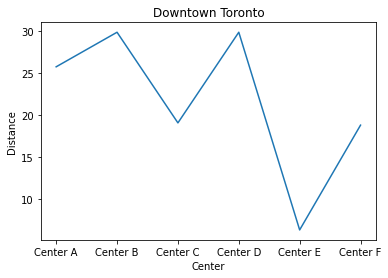

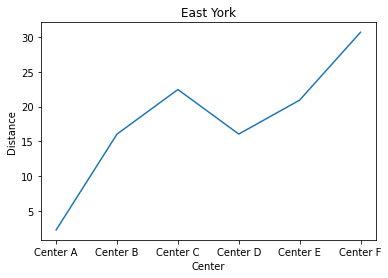

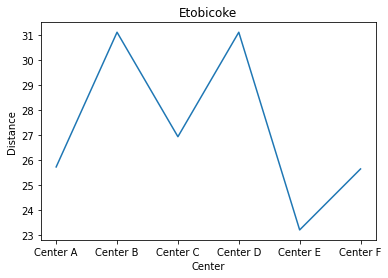

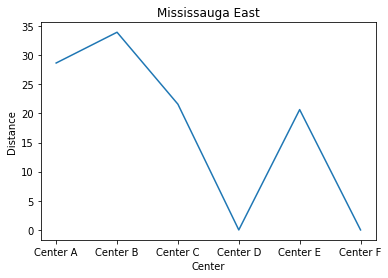

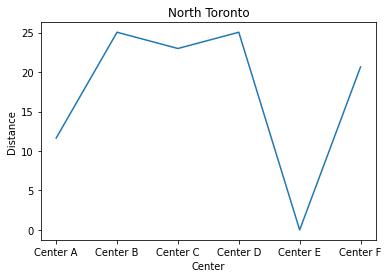

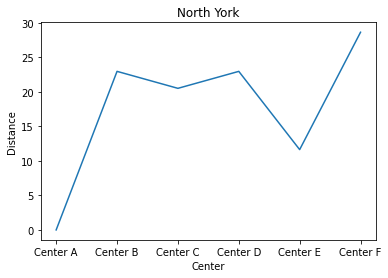

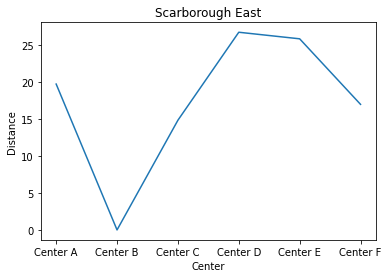

In [64]:
for i in zones:
    plt.title(i)
    sns.lineplot(x='Center',y='Distance',data=df_dist[df_dist['Region']==i])
    plt.show()

In [65]:
get_as_df(xvar)

Served                                          \
Center                 Center A  Center B  Center C  Center D  Center E   
Year Region                                                               
2022 Downtown Toronto       0.0       0.0       0.0       0.0  397296.0   
     East York         275251.0       0.0       0.0       0.0       0.0   
     Etobicoke              0.0    4099.0  296586.0   15546.0  141577.0   
     Mississauga East       0.0       0.0       0.0  406851.0       0.0   
     North Toronto          0.0       0.0       0.0       0.0  417190.0   
     North York        508686.0       0.0       0.0       0.0       0.0   
     Scarborough East       0.0  445901.0       0.0       0.0       0.0   
2023 Downtown Toronto       0.0       0.0       0.0       0.0  412507.0   
     East York         285828.0       0.0       0.0       0.0       0.0   
     Etobicoke              0.0       0.0  296586.0       0.0  178927.0   
     Mississauga East       0.0       0.0       0.0  422397.0       0.0   
     North Toronto          0.0       0.0       0.0       0.0  433025.0   
     North York        528428.0       0.0       0.0       0.0       0.0   
     Scarborough East       0.0  462886.0       0.0       0.0       0.0   
2024 Downtown Toronto       0.0       0.0       0.0       0.0  427718.0   
     East York         296406.0       0.0       0.0       0.0       0.0   
     Etobicoke              0.0       0.0  296586.0       0.0  196632.0   
     Mississauga East       0.0       0.0       0.0  437943.0       0.0   
     North Toronto          0.0       0.0       0.0       0.0  448860.0   
     North York        548169.0       0.0       0.0       0.0       0.0   
     Scarborough East       0.0  479871.0       0.0       0.0       0.0   

                                
Center                Center F  
Year Region                     
2022 Downtown Toronto      0.0  
     East York             0.0  
     Etobicoke             0.0  
     Mississauga East      0.0  
     North Toronto         0.0  
     North York            0.0  
     Scarborough East      0.0  
2023 Downtown Toronto      0.0  
     East York             0.0  
     Etobicoke             0.0  
     Mississauga East      0.0  
     North Toronto         0.0  
     North York            0.0  
     Scarborough East      0.0  
2024 Downtown Toronto      0.0  
     East York             0.0  
     Etobicoke             0.0  
     Mississauga East      0.0  
     North Toronto         0.0  
     North York            0.0  
     Scarborough East      0.0

In [66]:
workers_get_as_df(xvar)

Workers_Allocated                                      \
Center                         Center A Center B Center C Center D Center E   
Year Region                                                                   
2022 Downtown Toronto                 0        0        0        0      265   
     East York                      184        0        0        0        0   
     Etobicoke                        0        3      198       10       94   
     Mississauga East                 0        0        0      271        0   
     North Toronto                    0        0        0        0      278   
     North York                     339        0        0        0        0   
     Scarborough East                 0      297        0        0        0   
2023 Downtown Toronto                 0        0        0        0      275   
     East York                      191        0        0        0        0   
     Etobicoke                        0        0      198        0      119   
     Mississauga East                 0        0        0      282        0   
     North Toronto                    0        0        0        0      289   
     North York                     352        0        0        0        0   
     Scarborough East                 0      309        0        0        0   
2024 Downtown Toronto                 0        0        0        0      285   
     East York                      198        0        0        0        0   
     Etobicoke                        0        0      198        0      131   
     Mississauga East                 0        0        0      292        0   
     North Toronto                    0        0        0        0      299   
     North York                     365        0        0        0        0   
     Scarborough East                 0      320        0        0        0   

                                
Center                Center F  
Year Region                     
2022 Downtown Toronto        0  
     East York               0  
     Etobicoke               0  
     Mississauga East        0  
     North Toronto           0  
     North York              0  
     Scarborough East        0  
2023 Downtown Toronto        0  
     East York               0  
     Etobicoke               0  
     Mississauga East        0  
     North Toronto           0  
     North York              0  
     Scarborough East        0  
2024 Downtown Toronto        0  
     East York               0  
     Etobicoke               0  
     Mississauga East        0  
     North Toronto           0  
     North York              0  
     Scarborough East        0

___
## Further Analysis

In [67]:
def sensitivity_fn(r=1, hrs=6, days=250, wage = 37.85, hiring_cost = 15000):
    
    """
    Function for sensitivity analysis
    
    r = proportion of total demand met
    hrs = on averege number of hours worked in a day 
    days = number of days a medical professional works in a year
    wage = hourly wage provided to a medical worker
    hiring_cost = the hiring cost associated with acquiring a new worker
    
    """

    #### VARIABLES ------------------------------------------------------------------------------------

    # Variables: if a depot is opened/allocated
    yvar = pulp.LpVariable.dict("y", (depots, [2021]+periods), cat=pulp.LpBinary)

    # Variables: amount of demand from each zone allocated to depot, per scenario
    xvar = pulp.LpVariable.dict("x", (depots, zones, periods), lowBound=0.0, cat=pulp.LpContinuous)

    # Worker flow
    wvar = pulp.LpVariable.dict("w", (depots, [2021]+periods), lowBound=0, cat=pulp.LpContinuous)

    # New hires
    hvar = pulp.LpVariable.dict("h", (depots, periods), lowBound=0, cat=pulp.LpContinuous)

    #### MODEL-----------------------------------------------------------------------------------------

    locationModel_0 = pulp.LpProblem(name="LocationModel", sense=pulp.LpMinimize)

    #### CONSTRAINTS-----------------------------------------------------------------------------------------

    for t in periods:

        for j in zones:
            # Contraint: demand must be satisfied in all scenarios
            locationModel_0 += (pulp.lpSum( [xvar[(i,j,t)] for i in depots] ) == r*zonedemand[(j,t)])

        for i in depots:
            # Constraint: depot capacities must be observed in all scenarios
            locationModel_0 += pulp.lpSum( [xvar[(i,j,t)] for j in zones] ) <= depotcapacity[i] * yvar[(i,t)]

            # Maximum number of hires
            locationModel_0 += pulp.lpSum( hvar[(i,t)] ) <= 300

            # Worker flow -  Balance of flow constraints
            if t == 2022:
                locationModel_0 += pulp.lpSum( [ wvar[(i,t-1)] for i in depots ] ) <= (total_MPs)

            numworkers = wvar[(i,t-1)] + hvar[(i,t)]
            locationModel_0 += (wvar[(i,t)] == numworkers)

            # Capacity limited by workers
            locationModel_0 += pulp.lpSum( [xvar[(i,j,t)] for j in zones] ) <= days * hrs * wvar[(i,t)]



        #Constraints for opening of new centers
        for i in ['Center A', 'Center B', 'Center C', 'Center D']:
            locationModel_0 += ( yvar[(i, 2021)] == 1 )
            locationModel_0 += ( yvar[(i, t)] == 1 )

        for i in ['Center E', 'Center F']: 
            locationModel_0 += ( yvar[(i, 2021)] == 0 )
            locationModel_0 += ( yvar[(i, t)] >= yvar[(i, t-1)] )   


    #### Objective function-----------------------------------------------------------------------------------------        

    # Depot allocation costs
    obj_0 = pulp.lpSum([ depotcost_open[i] * yvar[(i,2024)] for i in depots] )

    for t in periods:
        # Distance costs
        obj_0 += pulp.lpSum( [ depotzonecost[(i,j)] * xvar[(i,j,t)] for i in depots for j in zones ] )

        obj_0 += pulp.lpSum([ depotcost_opt[i] * yvar[(i,t)] for i in depots] )

        # Workers' pay
        obj_0 += pulp.lpSum( [ (wage * days * hrs) * (1.025**(t-2022)) * wvar[(i,t)] for i in depots ] )

        # Hiring costs
        obj_0 += pulp.lpSum( [ hiring_cost * hvar[(i,t)] for i in depots ] )

    # Add objective to model
    locationModel_0 += obj_0

    #### Solving -----------------------------------------------------------------------------------------        

    locationModel_0.solve()
    status_x = pulp.LpStatus[locationModel_0.status]
    

    #### Results -----------------------------------------------------------------------------------------        

    totalCost = np.round(pulp.value(locationModel_0.objective),2)
    totalCost = np.round(totalCost/1e6,4)

    # Calculating Revenue
    total_hrs_served = 0
    hired_ttl = 0
    for t in periods:
        for i in depots:
            hired_ttl+= hvar[(i,t)].varValue
            for j in zones:
                total_hrs_served += xvar[(i,j,t)].varValue

    total_revenue = total_hrs_served*42
    total_revenue = np.round(total_revenue/1e6,4)

    diff = np.round((total_revenue-totalCost),4)

    return diff,hired_ttl,status_x

### Analyzing the demand 

In [68]:
dict_r = {'Portion':[],'Profits':[],'Hired':[]}
for r in np.arange(0.01,1.01,0.01):
    dict_r['Portion'].append(r)
    prof,s,v = sensitivity_fn(r=r)
    dict_r['Hired'].append(s)
    dict_r['Profits'].append(prof)
    

Text(0, 0.5, 'Profits / Losses')

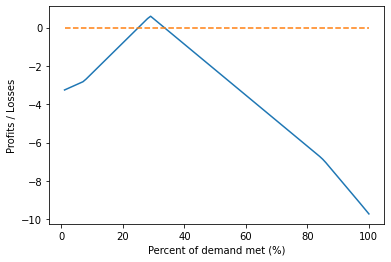

In [69]:
df_sen = pd.DataFrame(dict_r)
df_sen['Portion'] *= 100 

plt.figure()
sns.lineplot(x='Portion', y='Profits',data = df_sen)
sns.lineplot(x='Portion', y=0,linestyle = 'dashed',data = df_sen)
plt.xlabel("Percent of demand met (%)")
plt.ylabel("Profits / Losses")

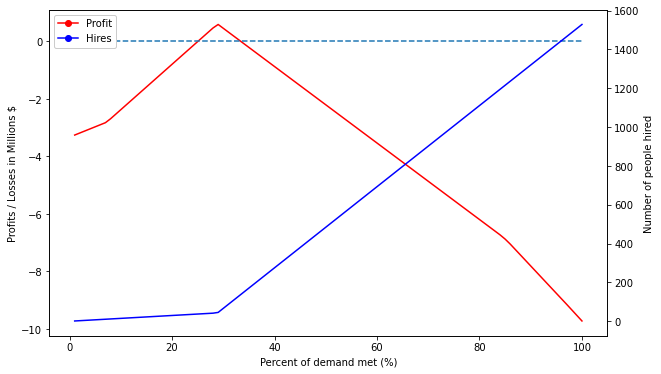

In [70]:
from matplotlib.lines import Line2D

plt.figure(figsize=(10,6))

g = sns.lineplot(data=df_sen, x='Portion', y='Profits',color='r')
plt.ylabel("Profits / Losses in Millions $")
sns.lineplot(x='Portion', y=0,linestyle = 'dashed',data = df_sen)
plt.xlabel("Percent of demand met (%)")
sns.lineplot(data=df_sen, x='Portion', y='Hired', color='b', ax=g.axes.twinx())


g.legend(handles=[Line2D([], [], marker='o', color='r', label='Profit'),
                  Line2D([], [], marker='o', color='b', label='Hires')], 
         loc='upper left', fontsize='medium', framealpha=1)


plt.ylabel("Number of people hired")

plt.show()

In [71]:
df_sen[df_sen['Profits']>0]['Portion'].max()

33.0

In [72]:
df_sen[df_sen['Portion'] == df_sen[df_sen['Profits']>0]['Portion'].max()]

,Portion,Profits,Hired
32,33.0,0.0559,129.0807


### Finding out the upper limit of the demand that can be met

In [73]:
dict_r = {'Portion':[],'Profits':[],'Hired':[],'Solution':[]}
for r in np.arange(1,2,0.1):
    dict_r['Portion'].append(r)
    prof,s,v = sensitivity_fn(r=r)
    dict_r['Hired'].append(s)
    dict_r['Profits'].append(prof)
    dict_r['Solution'].append(v)
pd.DataFrame(dict_r)   

,Portion,Profits,Hired,Solution
0,1.0,-9.7240,1528.123334,Optimal
1,1.1,-12.0982,1736.935666,Optimal
2,1.2,-15.4883,1945.748000,Optimal
3,1.3,-17.8424,2154.560334,Infeasible
4,1.4,-21.4627,2363.372667,Infeasible
5,1.5,-25.5128,2572.185000,Infeasible
6,1.6,-28.6808,2780.997334,Infeasible
7,1.7,-32.5146,2989.809666,Infeasible
8,1.8,-36.7199,3198.622000,Infeasible
9,1.9,-41.0242,3407.434334,Infeasible


The existing model can only accomodate 120% of the total demand

### Number of hours worked

In [74]:
work_hrs = {'Hours_Worked':[],'Profits':[]}
for h in np.arange(3,9.5,0.5):
    profits, v, status = sensitivity_fn(hrs=h)
    work_hrs['Hours_Worked'].append(h)
    work_hrs['Profits'].append(profits)

In [75]:
pd.DataFrame(work_hrs)

,Hours_Worked,Profits
0,3.0,-50.1543
1,3.5,-39.5695
2,4.0,-29.4347
3,4.5,-23.3834
4,5.0,-18.5346
5,5.5,-13.3728
6,6.0,-9.7240
7,6.5,-6.8984
8,7.0,-4.4327
9,7.5,-2.5910


### Harsh analysis

In [76]:
def sensitivity_fn_hrs(r=1, total_hrs=250*6, wage = 37.85, hiring_cost = 15000):

    
    """
    Function for sensitivity analysis focused on total number of hours
    
    r = proportion of total demand met
    total_hrs = number of hours a medical professional works in a year
    wage = hourly wage provided to a medical worker
    hiring_cost = the hiring cost associated with acquiring a new worker
    
    """
    
    #### VARIABLES ------------------------------------------------------------------------------------

    # Variables: if a depot is opened/allocated
    yvar = pulp.LpVariable.dict("y", (depots, [2021]+periods), cat=pulp.LpBinary)

    # Variables: amount of demand from each zone allocated to depot, per scenario
    xvar = pulp.LpVariable.dict("x", (depots, zones, periods), lowBound=0.0, cat=pulp.LpContinuous)

    # Worker flow
    wvar = pulp.LpVariable.dict("w", (depots, [2021]+periods), lowBound=0, cat=pulp.LpContinuous)

    # New hires
    hvar = pulp.LpVariable.dict("h", (depots, periods), lowBound=0, cat=pulp.LpContinuous)

    #### MODEL-----------------------------------------------------------------------------------------

    locationModel_0 = pulp.LpProblem(name="LocationModel", sense=pulp.LpMinimize)

    #### CONSTRAINTS-----------------------------------------------------------------------------------------

    for t in periods:

        for j in zones:
            # Contraint: demand must be satisfied in all scenarios
            locationModel_0 += (pulp.lpSum( [xvar[(i,j,t)] for i in depots] ) == r*zonedemand[(j,t)])

        for i in depots:
            # Constraint: depot capacities must be observed in all scenarios
            locationModel_0 += pulp.lpSum( [xvar[(i,j,t)] for j in zones] ) <= depotcapacity[i] * yvar[(i,t)]

            # Maximum number of hires
            locationModel_0 += pulp.lpSum( hvar[(i,t)] ) <= 300

            # Worker flow -  Balance of flow constraints
            if t == 2022:
                locationModel_0 += pulp.lpSum( [ wvar[(i,t-1)] for i in depots ] ) <= (total_MPs)

            numworkers = wvar[(i,t-1)] + hvar[(i,t)]
            locationModel_0 += (wvar[(i,t)] == numworkers)

            # Capacity limited by workers
            locationModel_0 += pulp.lpSum( [xvar[(i,j,t)] for j in zones] ) <= total_hrs * wvar[(i,t)]



        #Constraints for opening of new centers
        for i in ['Center A', 'Center B', 'Center C', 'Center D']:
            locationModel_0 += ( yvar[(i, 2021)] == 1 )
            locationModel_0 += ( yvar[(i, t)] == 1 )

        for i in ['Center E', 'Center F']: 
            locationModel_0 += ( yvar[(i, 2021)] == 0 )
            locationModel_0 += ( yvar[(i, t)] >= yvar[(i, t-1)] )   


    #### Objective function-----------------------------------------------------------------------------------------        

    # Depot allocation costs
    obj_0 = pulp.lpSum([ depotcost_open[i] * yvar[(i,2024)] for i in depots] )

    for t in periods:
        # Distance costs
        obj_0 += pulp.lpSum( [ depotzonecost[(i,j)] * xvar[(i,j,t)] for i in depots for j in zones ] )

        obj_0 += pulp.lpSum([ depotcost_opt[i] * yvar[(i,t)] for i in depots] )

        # Workers' pay
        obj_0 += pulp.lpSum( [ (wage * total_hrs) * (1.025**(t-2022)) * wvar[(i,t)] for i in depots ] )

        # Hiring costs
        obj_0 += pulp.lpSum( [ hiring_cost * hvar[(i,t)] for i in depots ] )

    # Add objective to model
    locationModel_0 += obj_0

    #### Solving -----------------------------------------------------------------------------------------        

    locationModel_0.solve()
    status_x = pulp.LpStatus[locationModel_0.status]
    

    #### Results -----------------------------------------------------------------------------------------        

    totalCost = np.round(pulp.value(locationModel_0.objective),2)
    totalCost = np.round(totalCost/1e6,4)

    # Calculating Revenue
    total_hrs_served = 0
    hired_ttl = 0
    for t in periods:
        for i in depots:
            hired_ttl+= hvar[(i,t)].varValue
            for j in zones:
                total_hrs_served += xvar[(i,j,t)].varValue

    total_revenue = total_hrs_served*42
    total_revenue = np.round(total_revenue/1e6,4)

    diff = np.round((total_revenue-totalCost),4)

    return diff,hired_ttl,status_x

In [77]:
x = 250*6
y=261*6

work_hrs = {'Total_Hours_Worked':[],'Profits':[],'Status':[]}

for hrs in np.arange(x,y+5,5):
    profits, v, status = sensitivity_fn_hrs(total_hrs=hrs)
    work_hrs['Total_Hours_Worked'].append(hrs)
    work_hrs['Profits'].append(profits)
    work_hrs['Status'].append(status)
pd.DataFrame(work_hrs)

,Total_Hours_Worked,Profits,Status
0,1500,-9.7240,Optimal
1,1505,-9.6024,Optimal
2,1510,-9.4816,Optimal
3,1515,-9.3615,Optimal
4,1520,-9.2420,Optimal
5,1525,-9.1232,Optimal
6,1530,-9.0051,Optimal
7,1535,-8.8876,Optimal
8,1540,-8.7708,Optimal
9,1545,-8.6551,Optimal


### Analyzing centers E and F

In [78]:
df_dist[df_dist['Center'] == 'Center E'].sort_values(by = 'Distance')

,Center,Region,Distance
32,Center E,North Toronto,0.00
28,Center E,Downtown Toronto,6.37
33,Center E,North York,11.64
31,Center E,Mississauga East,20.65
29,Center E,East York,20.93
30,Center E,Etobicoke,23.20
34,Center E,Scarborough East,25.89


In [79]:
df_dist[df_dist['Center'] == 'Center F'].sort_values(by = 'Distance')

,Center,Region,Distance
38,Center F,Mississauga East,0.00
41,Center F,Scarborough East,17.01
35,Center F,Downtown Toronto,18.83
39,Center F,North Toronto,20.65
37,Center F,Etobicoke,25.64
40,Center F,North York,28.65
36,Center F,East York,30.70


In [80]:
df_dist[df_dist['Region'] == 'North Toronto'].sort_values(by = 'Distance')

,Center,Region,Distance
32,Center E,North Toronto,0.00
4,Center A,North Toronto,11.64
39,Center F,North Toronto,20.65
18,Center C,North Toronto,22.99
11,Center B,North Toronto,25.05
25,Center D,North Toronto,25.05


In [81]:
df_dist[df_dist['Region'] == 'Mississauga East'].sort_values(by = 'Distance')

,Center,Region,Distance
24,Center D,Mississauga East,0.00
38,Center F,Mississauga East,0.00
31,Center E,Mississauga East,20.65
17,Center C,Mississauga East,21.58
3,Center A,Mississauga East,28.65
10,Center B,Mississauga East,33.93


In [82]:
def sensitivity_fn_ef(e,f,r=1, hrs=6, days=250, wage = 37.85, hiring_cost = 15000):
    
    """
    Function for new store analysis
    
    e = Whether center E is opened or not : 0 = No, 1 = Yes
    f = Whether center F is opened or not : 0 = No, 1 = Yes
    
    r = proportion of total demand met
    hrs = on averege number of hours worked in a day 
    days = number of days a medical professional works in a year
    wage = hourly wage provided to a medical worker
    hiring_cost = the hiring cost associated with acquiring a new worker
    
    """
    
    #### VARIABLES ------------------------------------------------------------------------------------

    # Variables: if a depot is opened/allocated
    yvar = pulp.LpVariable.dict("y", (depots, [2021]+periods), cat=pulp.LpBinary)

    # Variables: amount of demand from each zone allocated to depot, per scenario
    xvar = pulp.LpVariable.dict("x", (depots, zones, periods), lowBound=0.0, cat=pulp.LpContinuous)

    # Worker flow
    wvar = pulp.LpVariable.dict("w", (depots, [2021]+periods), lowBound=0, cat=pulp.LpContinuous)

    # New hires
    hvar = pulp.LpVariable.dict("h", (depots, periods), lowBound=0, cat=pulp.LpContinuous)

    #### MODEL-----------------------------------------------------------------------------------------

    locationModel_0 = pulp.LpProblem(name="LocationModel", sense=pulp.LpMinimize)

    #### CONSTRAINTS-----------------------------------------------------------------------------------------

    for t in periods:

        for j in zones:
            # Contraint: demand must be satisfied in all scenarios
            locationModel_0 += (pulp.lpSum( [xvar[(i,j,t)] for i in depots] ) == r*zonedemand[(j,t)])

        for i in depots:
            # Constraint: depot capacities must be observed in all scenarios
            locationModel_0 += pulp.lpSum( [xvar[(i,j,t)] for j in zones] ) <= depotcapacity[i] * yvar[(i,t)]

            # Maximum number of hires
            locationModel_0 += pulp.lpSum( hvar[(i,t)] ) <= 300

            # Worker flow -  Balance of flow constraints
            if t == 2022:
                locationModel_0 += pulp.lpSum( [ wvar[(i,t-1)] for i in depots ] ) <= (total_MPs)

            numworkers = wvar[(i,t-1)] + hvar[(i,t)]
            locationModel_0 += (wvar[(i,t)] == numworkers)

            # Capacity limited by workers
            locationModel_0 += pulp.lpSum( [xvar[(i,j,t)] for j in zones] ) <= days * hrs * wvar[(i,t)]



        #Constraints for opening of new centers
        for i in ['Center A', 'Center B', 'Center C', 'Center D']:
            locationModel_0 += ( yvar[(i, 2021)] == 1 )
            locationModel_0 += ( yvar[(i, t)] == 1 )

        #Enforcing conditions on Centers E and F
        locationModel_0 += ( yvar[('Center E', 2021)] == 0 )
        locationModel_0 += ( yvar[('Center E', t)] == e )
        locationModel_0 += ( yvar[('Center F', 2021)] == 0 )
        locationModel_0 += ( yvar[('Center F', t)] == f )


    #### Objective function-----------------------------------------------------------------------------------------        

    # Depot allocation costs
    obj_0 = pulp.lpSum([ depotcost_open[i] * yvar[(i,2024)] for i in depots] )

    for t in periods:
        # Distance costs
        obj_0 += pulp.lpSum( [ depotzonecost[(i,j)] * xvar[(i,j,t)] for i in depots for j in zones ] )

        obj_0 += pulp.lpSum([ depotcost_opt[i] * yvar[(i,t)] for i in depots] )

        # Workers' pay
        obj_0 += pulp.lpSum( [ (wage * days * hrs) * (1.025**(t-2022)) * wvar[(i,t)] for i in depots ] )

        # Hiring costs
        obj_0 += pulp.lpSum( [ hiring_cost * hvar[(i,t)] for i in depots ] )

    # Add objective to model
    locationModel_0 += obj_0

    #### Solving -----------------------------------------------------------------------------------------        

    locationModel_0.solve()
    status_x = pulp.LpStatus[locationModel_0.status]
    

    #### Results -----------------------------------------------------------------------------------------        

    totalCost = np.round(pulp.value(locationModel_0.objective),2)
    totalCost = np.round(totalCost/1e6,4)

    # Calculating Revenue
    total_hrs_served = 0
    hired_ttl = 0
    for t in periods:
        for i in depots:
            hired_ttl+= hvar[(i,t)].varValue
            for j in zones:
                total_hrs_served += xvar[(i,j,t)].varValue

    total_revenue = total_hrs_served*42
    total_revenue = np.round(total_revenue/1e6,4)

    diff = np.round((total_revenue-totalCost),4)

    return diff,hired_ttl,status_x

In [83]:
for e in [0,1]:
    print()
    if e == 0:
        print("Center E closed")
    else:
        print("Center E is Open")
    for f in [0,1]:
        print()
        if f == 0:
            print("\tCenter F closed")
        else:
            print("\tCenter F is Open")
        prof, h, s = sensitivity_fn_ef(e,f)
        print("\t\tProfits: ",prof, " | Solution : ",s)



Center E closed

	Center F closed
		Profits:  -18.0287  | Solution :  Infeasible

	Center F is Open
		Profits:  -17.4248  | Solution :  Optimal

Center E is Open

	Center F closed
		Profits:  -9.724  | Solution :  Optimal

	Center F is Open
		Profits:  -10.0307  | Solution :  Optimal


# Thank You!

By Yash Bhatnagar